
Epoch 1/10


Evaluating: 100%|██████████| 110/110 [00:36<00:00,  3.02it/s]


Train Loss: 0.8493 | Val Loss: 0.8177 | Val Acc: 0.6304 | Val F1: 0.4905

Epoch 2/10


Evaluating: 100%|██████████| 110/110 [00:34<00:00,  3.21it/s]


Train Loss: 0.8101 | Val Loss: 0.8003 | Val Acc: 0.6304 | Val F1: 0.4905

Epoch 3/10


Evaluating: 100%|██████████| 110/110 [00:34<00:00,  3.21it/s]


Train Loss: 0.7192 | Val Loss: 0.7914 | Val Acc: 0.6556 | Val F1: 0.5780

Epoch 4/10


Evaluating: 100%|██████████| 110/110 [00:34<00:00,  3.20it/s]


Train Loss: 0.5869 | Val Loss: 0.8315 | Val Acc: 0.6579 | Val F1: 0.6353

Epoch 5/10


Evaluating: 100%|██████████| 110/110 [00:34<00:00,  3.19it/s]


Train Loss: 0.3321 | Val Loss: 0.9595 | Val Acc: 0.6533 | Val F1: 0.6288

Epoch 6/10


Evaluating: 100%|██████████| 110/110 [00:34<00:00,  3.18it/s]


Train Loss: 0.1516 | Val Loss: 1.1503 | Val Acc: 0.6304 | Val F1: 0.6167

Epoch 7/10


Evaluating: 100%|██████████| 110/110 [00:34<00:00,  3.20it/s]


Train Loss: 0.0601 | Val Loss: 1.2748 | Val Acc: 0.6590 | Val F1: 0.6356

Epoch 8/10


Evaluating: 100%|██████████| 110/110 [00:35<00:00,  3.12it/s]


Train Loss: 0.0330 | Val Loss: 1.4175 | Val Acc: 0.6636 | Val F1: 0.6331

Epoch 9/10


Evaluating: 100%|██████████| 110/110 [00:33<00:00,  3.24it/s]


Train Loss: 0.0202 | Val Loss: 1.4511 | Val Acc: 0.6442 | Val F1: 0.6244

Epoch 10/10


Evaluating: 100%|██████████| 110/110 [00:33<00:00,  3.27it/s]


Train Loss: 0.0156 | Val Loss: 1.5098 | Val Acc: 0.6510 | Val F1: 0.6280

Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.81      0.76       552
    positive       0.51      0.45      0.48       267
     neutral       0.22      0.04      0.06        55

    accuracy                           0.65       874
   macro avg       0.48      0.43      0.43       874
weighted avg       0.62      0.65      0.63       874



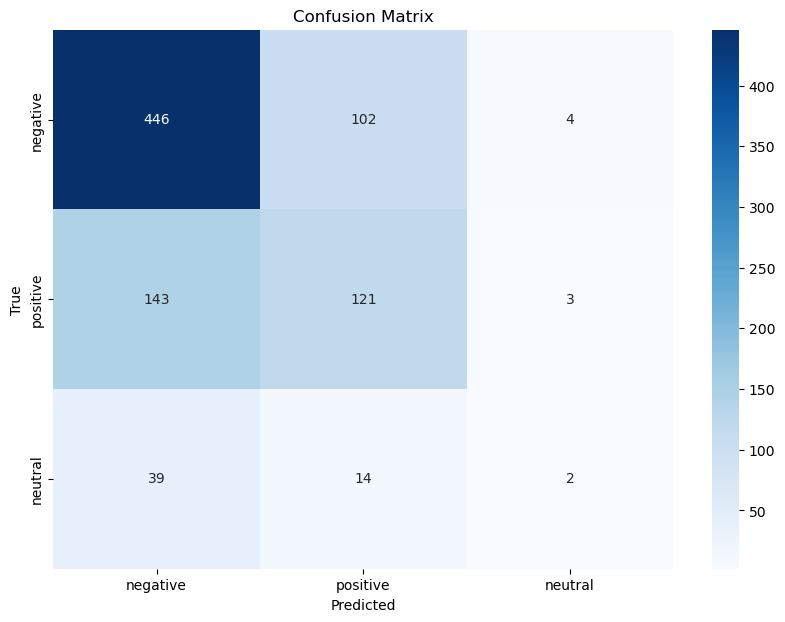

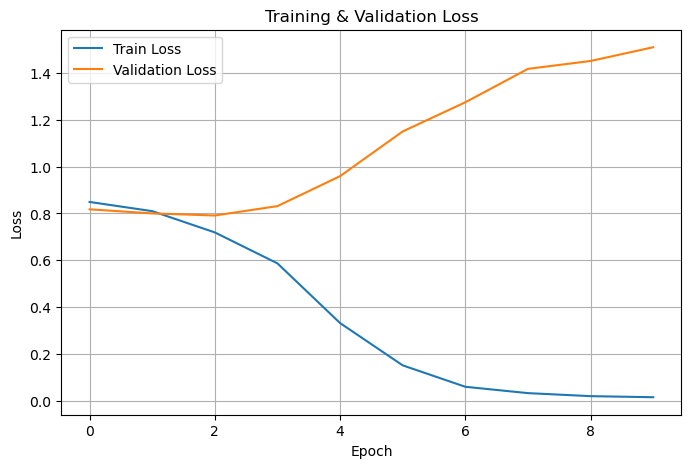

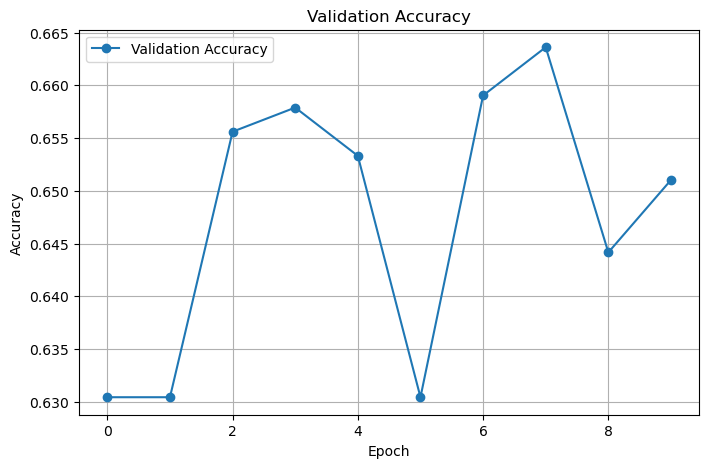

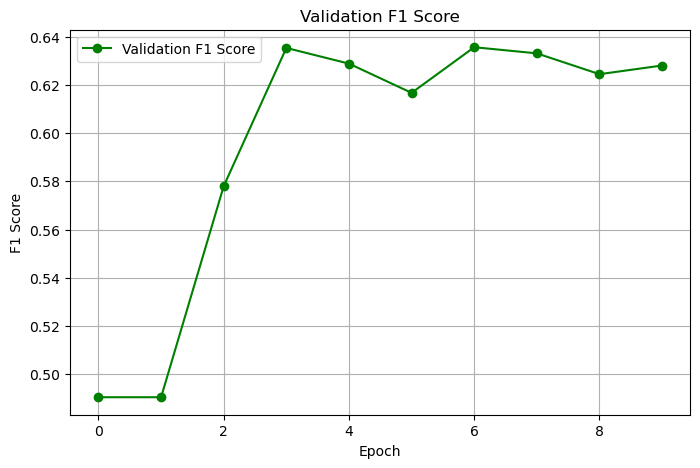

: 

In [ ]:
# ====================== Imports ======================
import os
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import ViltProcessor, ViltModel
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Fix file names by replacing spaces with underscores
folder = "Dataset/Memes"
for filename in os.listdir(folder):
    new_filename = filename.replace(' ', '_')
    os.rename(os.path.join(folder, filename), os.path.join(folder, new_filename))

def clean_filename(name):
    name = re.sub(r'\s+', ' ', str(name).strip())
    name = name.replace(' ', '_')
    return name

# ====================== CONFIG ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_DIR = "Dataset/Memes"
CSV_PATH = "Dataset/multi-sent.xlsx"
NUM_LABELS = 3
LABEL_MAP = {'negative': 0, 'positive': 1, 'neutral': 2}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}
BATCH_SIZE = 8
EPOCHS = 10

df = pd.read_excel(CSV_PATH)
df['image_name'] = df['image_name'].apply(clean_filename)

# ====================== Dataset ======================
class MemeDataset(Dataset):
    def __init__(self, records, img_dir):
        self.data = records
        self.img_dir = img_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data[idx]
        image_name = clean_filename(row['image_name'])
        image_path = os.path.join(self.img_dir, image_name)
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")

        image = Image.open(image_path).convert("RGB")  # raw PIL image
        text = str(row['Captions'])
        label = LABEL_MAP[row['Label_Sentiment']]

        return {"image": image, "text": text, "labels": label}


# ====================== Custom Collate ======================
def custom_collate(batch):
    texts = [item['text'] for item in batch]
    images = [item['image'] for item in batch]
    labels = torch.tensor([item['labels'] for item in batch])

    # Batch-process texts and images together with ViltProcessor
    inputs = processor(
        text=texts,
        images=images,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )

    # Remove token_type_ids if present (not supported by ViLT)
    if 'token_type_ids' in inputs:
        del inputs['token_type_ids']

    inputs["labels"] = labels
    return inputs


# ====================== Model ======================
class ViltClassificationHead(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.vilt = ViltModel.from_pretrained("dandelin/vilt-b32-mlm")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.vilt.config.hidden_size, num_labels)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, pixel_values, labels=None):
        outputs = self.vilt(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            return_dict=True
        )
        pooled_output = self.dropout(outputs.pooler_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return {"loss": loss, "logits": logits}


# ====================== Train & Eval Functions ======================
def train(model, dataloader, optimizer):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training"):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels' and k != 'pixel_mask'}
        labels = batch['labels'].to(device)

        outputs = model(**inputs, labels=labels)
        loss = outputs["loss"]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            inputs = dict(batch)
            inputs.pop('labels')
            inputs.pop('pixel_mask', None)  # Remove pixel_mask if present
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = batch['labels'].to(device)

            outputs = model(**inputs, labels=labels)
            logits = outputs["logits"]
            loss = outputs["loss"]

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    return acc, avg_loss, all_preds, all_labels


# ====================== Run ======================
records = df.to_dict(orient="records")
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")

dataset = MemeDataset(records, IMG_DIR)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate)

model = ViltClassificationHead(num_labels=NUM_LABELS).to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

train_losses, val_losses = [], []
final_preds, final_labels = [], []
val_accuracies, val_f1s = [], []
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss = train(model, train_loader, optimizer)
    train_losses.append(train_loss)

    val_acc, val_loss, preds, labels = evaluate(model, val_loader)
    val_losses.append(val_loss)

    f1 = f1_score(labels, preds, average='weighted')
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {f1:.4f}")

    val_accuracies.append(val_acc)
    val_f1s.append(f1)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")

    scheduler.step()
    final_preds = preds
    final_labels = labels


# ========== Evaluation ==========
print("\nClassification Report:")
print(classification_report(final_labels, final_preds, target_names=LABEL_MAP.keys()))

# ========== Visualization ==========
os.makedirs("plots", exist_ok=True)

plt.figure(figsize=(10, 7))
conf_mat = confusion_matrix(final_labels, final_preds)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=LABEL_MAP.keys(), yticklabels=LABEL_MAP.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("plots/confusion_matrix.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()
plt.savefig("plots/loss_plot.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid()
plt.savefig("plots/accuracy_plot.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(val_f1s, label="Validation F1 Score", marker="o", color="green")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Score")
plt.legend()
plt.grid()
plt.savefig("plots/f1_score_plot.png")
plt.show()
